In [1]:
from pathlib import Path
from pybedtools import BedTool
import pandas as pd
old_output_dir = Path('/projects/ps-yeolab5/ABC_chisq_peaks/')
rep1 = 'Dan_multiplex1_K562_rep4'
rep2 = 'Dan_multiplex1_K562_rep6'

In [2]:
def get_sig_peak(rbp, rep, pval_cutoff = 3, fc_cutoff = 3):
    b = BedTool(old_output_dir/ rep/f'{rep}_{rbp}.peaks.normed.compressed.bed')
    b = b.filter(
        lambda region: float(region[3])>pval_cutoff and float(region[4])>fc_cutoff).sort().saveas()
    #print(b[0])
    b = b.merge(
        s = True, d = 5, o = ['max', 'max', 'distinct'], c = [4,5,6]).saveas()
    return b
def get_reproducible_peaks(rbp, pval_cutoff = 3, fc_cutoff = 3):
    r1 = get_sig_peak(rbp, rep1, pval_cutoff = pval_cutoff, fc_cutoff = fc_cutoff)
    r2 = get_sig_peak(rbp, rep2, pval_cutoff = pval_cutoff, fc_cutoff = fc_cutoff)
    
    reproducible = r1.intersect(r2, s = True, u = True).saveas()
    return reproducible

In [3]:
window_bed = BedTool('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
window_col = pd.read_csv(window_bed.fn, sep = '\t', nrows = 5).columns.tolist()

In [24]:
def label_windows():
    rbps = [f.name.split('.')[0].split('_')[-1] for f in (old_output_dir/rep1).glob('*.peaks.normed.compressed.bed')]
    
    data = []
    count = []
    for rbp in rbps:
        reproducible_peak = get_reproducible_peaks(rbp)
        window = window_bed.intersect(reproducible_peak, s = True, F = 0.5, u = True).to_dataframe(names = window_col)
        
        window[rbp] = True
        data.append(window.set_index('name')[rbp])
        type_cnt = window['feature_type_top'].value_counts()
        type_cnt.name = rbp
        count.append(type_cnt)
    return pd.concat(data, axis = 1).fillna(False),  pd.concat(count, axis = 1).fillna(0)

In [21]:
rbps = [f.name.split('.')[0].split('_')[-1] for f in (old_output_dir/rep1).glob('*.peaks.normed.compressed.bed')]
    
data = []
count = []
for rbp in rbps:
    reproducible_peak = get_reproducible_peaks(rbp)
    window = window_bed.intersect(reproducible_peak, s = True, u = True, F = 0.5).to_dataframe(names = window_col)

    window[rbp] = True
    data.append(window.set_index('name')[rbp])
    type_cnt = window['feature_type_top'].value_counts()
    type_cnt.name = rbp
    count.append(type_cnt)

In [23]:
windows = pd.concat(data, axis = 1).fillna(False)

In [26]:
cnt = pd.concat(count, axis = 1).fillna(0)

In [28]:
cnt

,PRPF8,IGF2BP2,EIF3G,FAM120A,SF3B4,RBFOX2,ZC3H11A,DDX3,PUM2,LIN28B
SS5_ADJ,1520.0,0.0,0.0,0.0,5.0,33.0,0.0,0.0,1.0,3.0
EXON_MRNA,316.0,4.0,0.0,10.0,241.0,62.0,3.0,1.0,0.0,16.0
CDS,144.0,137.0,5.0,13.0,35.0,10.0,10.0,52.0,6.0,1049.0
SSB_ADJ,124.0,0.0,0.0,0.0,37.0,1.0,0.0,0.0,0.0,4.0
EXON_LNCRNA,79.0,9.0,0.0,47.0,47.0,27.0,1.0,7.0,2.0,23.0
UTR3,40.0,266.0,0.0,4342.0,36.0,44.0,46.0,0.0,19.0,379.0
CDS_STOP,36.0,7.0,0.0,8.0,6.0,0.0,4.0,0.0,0.0,83.0
INTRON,23.0,11.0,8.0,92.0,23.0,955.0,34.0,1.0,3.0,219.0
UTR5,19.0,2.0,114.0,8.0,26.0,4.0,1.0,273.0,0.0,67.0
EXON_SMALL,9.0,1.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,5.0


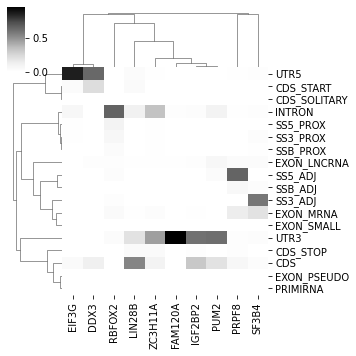

In [29]:
import seaborn as sns
sns.clustermap(cnt.div(cnt.sum(axis = 0), axis = 1), metric = 'correlation', cmap = 'Greys', figsize = (5,5))

In [31]:
windows.to_csv(f'{rep1}.{rep2}.reproducible_window.csv')